In [1]:
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
import networkx as nx
import collections
import matplotlib.pyplot as plt



In [2]:
def weisfeiler_lehman_hash(graph):
    colors = {node: data.get('label', 0) for node, data in graph.nodes(data=True)}

    for _ in range(len(graph.nodes())):  # Iterate enough times for convergence
        new_colors = {}
        for node in graph.nodes():
            neighbor_colors = sorted([colors[nbr] for nbr in graph.neighbors(node)])
            signature = (colors[node], tuple(neighbor_colors))
            new_colors[node] = hash(signature)  # Hash the signature to get a new color

        if new_colors == colors:
            break
        colors = new_colors

    canonical_hash = str(sorted(colors.values()))
    return canonical_hash

In [3]:
def find_isomorphic_groups_from_pyg(dataset):
    hashes = collections.defaultdict(list)

    for i, data in enumerate(dataset):
        g = to_networkx(data, to_undirected=True)

        # Use original node labels from PyG data if present
        if hasattr(data, 'x') and data.x is not None:
            # If node features are present, use the first feature as label (common for TUDataset)
            labels = data.x[:, 0].tolist() if len(data.x.shape) > 1 else data.x.tolist()
            nx.set_node_attributes(g, {node: int(labels[node]) for node in g.nodes()}, 'label')
        elif hasattr(data, 'node_label') and data.node_label is not None:
            labels = data.node_label.tolist()
            nx.set_node_attributes(g, {node: int(labels[node]) for node in g.nodes()}, 'label')
        # else: no label, default to 0 (handled by WL hash)

        if len(g) > 0:
            h = weisfeiler_lehman_hash(g)
            hashes[h].append(i)

    isomorphic_groups = {h: indices for h, indices in hashes.items() if len(indices) > 1}
    return isomorphic_groups

In [4]:
print("Loading and preprocessing the dataset...")
dataset = TUDataset(root='/tmp/AIDS', name='AIDS', use_node_attr=True)


isomorphic_groups = find_isomorphic_groups_from_pyg(dataset)
print(f"PyG groups: {len(isomorphic_groups)} groups, {sum(len(v) for v in isomorphic_groups.values())} graphs in groups.")

print("\n3. Isomorphism Statistics:")
if not isomorphic_groups:
    print("   No isomorphic graphs were found in the dataset.")
else:
    num_isomorphic_groups = len(isomorphic_groups)
    total_graphs_in_groups = sum(len(indices) for indices in isomorphic_groups.values())
    print(f"   - Total Isomorphic Groups Found: {num_isomorphic_groups}")
    print(f"   - Total Graphs in Isomorphic Groups: {total_graphs_in_groups}")

    print("\n   Isomorphic Group Details (Graph Indices):")
    # Sort groups by the first graph index for consistent output
    sorted_groups = sorted(isomorphic_groups.values(), key=lambda x: x[0])
    for i, group in enumerate(sorted_groups):
        print(f"     - Group {i+1}: {group}")

Loading and preprocessing the dataset...
PyG groups: 84 groups, 182 graphs in groups.

3. Isomorphism Statistics:
   - Total Isomorphic Groups Found: 84
   - Total Graphs in Isomorphic Groups: 182

   Isomorphic Group Details (Graph Indices):
     - Group 1: [18, 1832]
     - Group 2: [23, 1950]
     - Group 3: [26, 1184]
     - Group 4: [27, 666]
     - Group 5: [48, 877]
     - Group 6: [60, 1685]
     - Group 7: [63, 751]
     - Group 8: [78, 123]
     - Group 9: [90, 711]
     - Group 10: [120, 1825]
     - Group 11: [125, 1505]
     - Group 12: [127, 700]
     - Group 13: [138, 234]
     - Group 14: [142, 1909]
     - Group 15: [153, 1617]
     - Group 16: [160, 213]
     - Group 17: [187, 603]
     - Group 18: [189, 1004, 1711]
     - Group 19: [197, 951]
     - Group 20: [218, 239]
     - Group 21: [219, 1071]
     - Group 22: [230, 574]
     - Group 23: [232, 878]
     - Group 24: [235, 812]
     - Group 25: [244, 1196]
     - Group 26: [257, 856]
     - Group 27: [262, 509]
  

In [ ]:
# Sort groups by the first graph index for consistent output
sorted_groups = sorted(
    [(i+1, group) for i, group in enumerate(sorted(isomorphic_groups.values(), key=lambda x: x[0]))],
    key=lambda x: len(x[1]), reverse=True
)

for group_id, group in sorted_groups:
    print(f"     - Group {group_id} (size={len(group)}): {group}")



     - Group 53 (size=8): [709, 1270, 1454, 1585, 1607, 1809, 1964, 1977]
     - Group 18 (size=3): [189, 1004, 1711]
     - Group 37 (size=3): [435, 825, 1473]
     - Group 41 (size=3): [470, 651, 1739]
     - Group 48 (size=3): [592, 838, 1121]
     - Group 54 (size=3): [720, 839, 1329]
     - Group 55 (size=3): [763, 1458, 1776]
     - Group 60 (size=3): [853, 1084, 1836]
     - Group 82 (size=3): [1667, 1741, 1794]
     - Group 1 (size=2): [18, 1832]
     - Group 2 (size=2): [23, 1950]
     - Group 3 (size=2): [26, 1184]
     - Group 4 (size=2): [27, 666]
     - Group 5 (size=2): [48, 877]
     - Group 6 (size=2): [60, 1685]
     - Group 7 (size=2): [63, 751]
     - Group 8 (size=2): [78, 123]
     - Group 9 (size=2): [90, 711]
     - Group 10 (size=2): [120, 1825]
     - Group 11 (size=2): [125, 1505]
     - Group 12 (size=2): [127, 700]
     - Group 13 (size=2): [138, 234]
     - Group 14 (size=2): [142, 1909]
     - Group 15 (size=2): [153, 1617]
     - Group 16 (size=2): [160, 


Visualizing top isomeric group 53 (size=8)


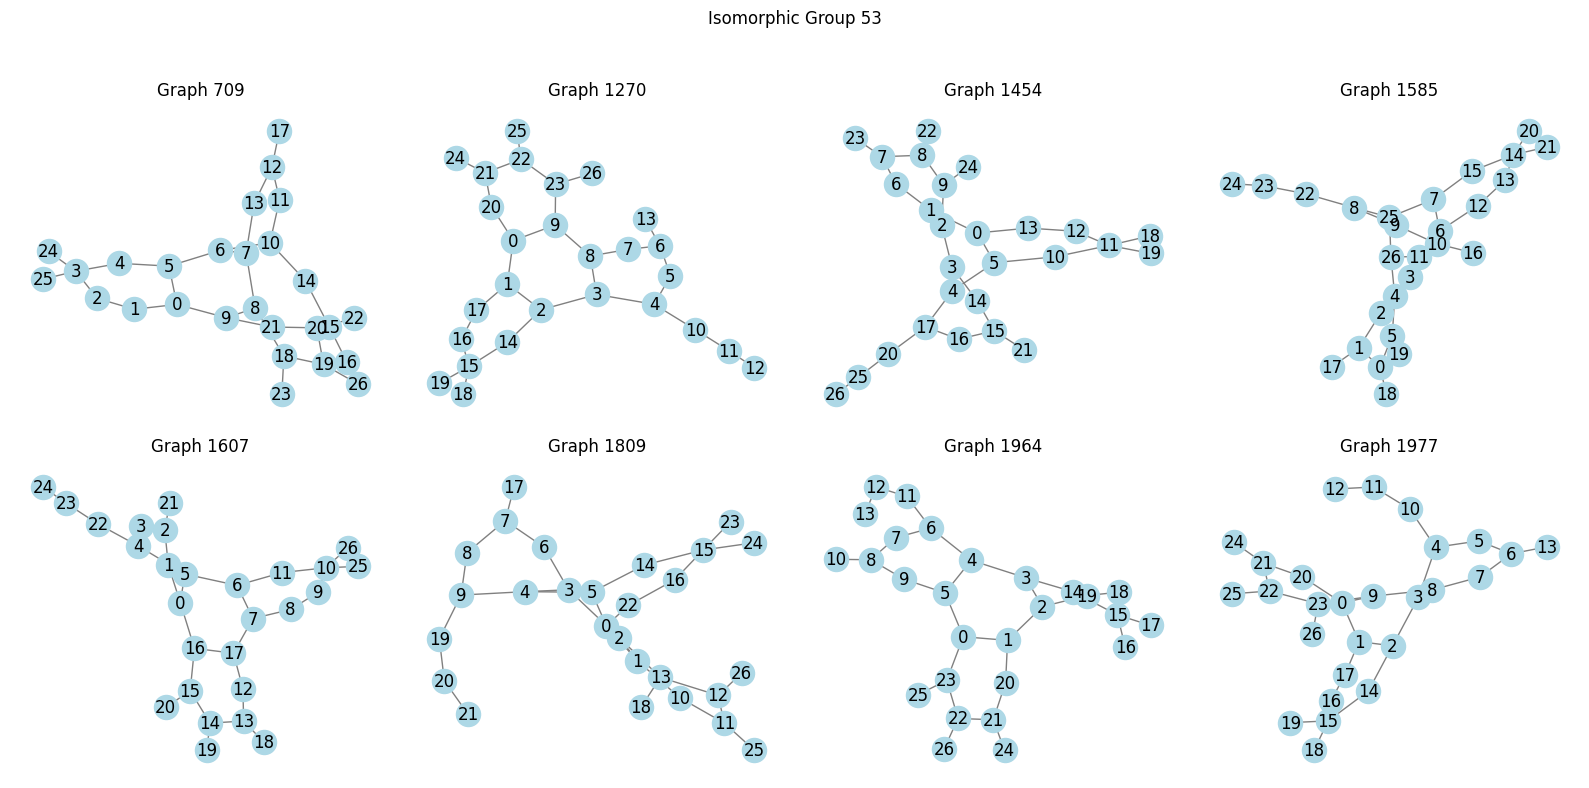


Visualizing second isomeric group 18 (size=3)


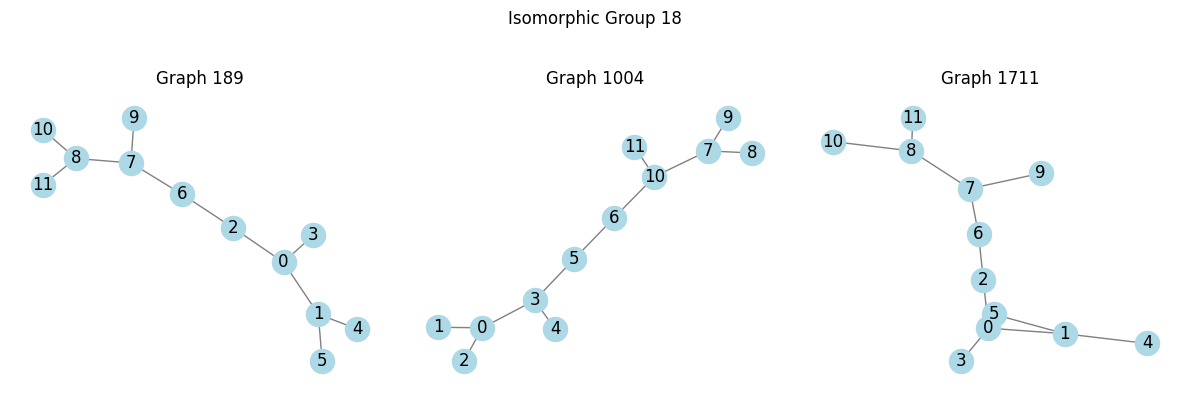

In [ ]:
def visualize_group(dataset, group, group_id):
    import matplotlib.pyplot as plt
    import networkx as nx
    from torch_geometric.utils import to_networkx
    import math
    n = len(group)
    cols = min(n, 4)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(4*cols, 4*rows))
    for i, graph_idx in enumerate(group):
        data = dataset[graph_idx]
        g = to_networkx(data, to_undirected=True)
        # Use node labels if present
        if hasattr(data, 'x') and data.x is not None:
            labels = data.x[:, 0].tolist() if len(data.x.shape) > 1 else data.x.tolist()
            nx.set_node_attributes(g, {node: int(labels[node]) for node in g.nodes()}, 'label')
        elif hasattr(data, 'node_label') and data.node_label is not None:
            labels = data.node_label.tolist()
            nx.set_node_attributes(g, {node: int(labels[node]) for node in g.nodes()}, 'label')
        plt.subplot(rows, cols, i + 1)
        nx.draw(g, with_labels=True, node_color='lightblue', edge_color='gray')
        plt.title(f"Graph {graph_idx}")
    plt.suptitle(f"Isomorphic Group {group_id}")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Visualize the top two isomeric groups
if len(sorted_groups) >= 2:
    group_id1, group1 = sorted_groups[0]
    group_id2, group2 = sorted_groups[1]
    print(f"\nVisualizing top isomeric group {group_id1} (size={len(group1)})")
    visualize_group(dataset, group1, group_id=group_id1)
    print(f"\nVisualizing second isomeric group {group_id2} (size={len(group2)})")
    visualize_group(dataset, group2, group_id=group_id2)

In [9]:
# Prove or disprove true isomorphism for the top two groups
import networkx as nx
from torch_geometric.utils import to_networkx

def are_all_graphs_isomorphic(dataset, group):
    nx_graphs = []
    for idx in group:
        data = dataset[idx]
        g = to_networkx(data, to_undirected=True)
        if hasattr(data, 'x') and data.x is not None:
            labels = data.x[:, 0].tolist() if len(data.x.shape) > 1 else data.x.tolist()
            nx.set_node_attributes(g, {node: int(labels[node]) for node in g.nodes()}, 'label')
        elif hasattr(data, 'node_label') and data.node_label is not None:
            labels = data.node_label.tolist()
            nx.set_node_attributes(g, {node: int(labels[node]) for node in g.nodes()}, 'label')
        nx_graphs.append(g)
    n = len(nx_graphs)
    for i in range(n):
        for j in range(i+1, n):
            GM = nx.isomorphism.GraphMatcher(nx_graphs[i], nx_graphs[j], node_match=lambda x, y: x['label'] == y['label'])
            if not GM.is_isomorphic():
                print(f"Graphs {group[i]} and {group[j]} are NOT isomorphic.")
                return False
    print("All graphs in the group are truly isomorphic.")
    return True

if len(sorted_groups) >= 2:
    print(f"\nChecking true isomorphism for group {group_id1}:")
    are_all_graphs_isomorphic(dataset, group1)
    print(f"\nChecking true isomorphism for group {group_id2}:")
    are_all_graphs_isomorphic(dataset, group2)


Checking true isomorphism for group 53:
All graphs in the group are truly isomorphic.

Checking true isomorphism for group 18:
All graphs in the group are truly isomorphic.


## Experiment B: Going Beyond the WL Test
In this section, we will:
- Check for true isomorphism using structural properties (degree sequences, cycle lengths, triangle counts).
- Attempt to construct explicit node-to-node isomorphisms for graphs in large WL-isomorphic groups.
- Try to find structural differences between graphs that the WL test cannot distinguish.

In [13]:
# Go beyond the WL test: check for structural differences in all WL-isomorphic groups
def analyze_structural_properties(graphs):
    """Return sorted degree sequence, two-hop neighbor degrees, triangle count, and four-cycle count for each graph."""
    properties = []
    for g in graphs:
        # Sorted degree sequence
        deg_seq = sorted([d for n, d in g.degree()])
        
        # Two-hop neighbor degrees
        two_hop_degrees = []
        for node in g.nodes():
            neighbors = set(g.neighbors(node))
            two_hop = set()
            for nbr in neighbors:
                two_hop.update(g.neighbors(nbr))
            two_hop.discard(node)
            two_hop -= neighbors
            two_hop_degrees.append(sorted([g.degree(n) for n in two_hop]))
        two_hop_degrees = sorted(two_hop_degrees)
        
        # Triangle count
        triangles = sum(nx.triangles(g).values()) // 3
        
        # Four-cycle count
        four_cycle_count = 0
        # For each pair of nodes, count common neighbors (potential 4-cycles)
        nodes = list(g.nodes())
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                common = set(g.neighbors(nodes[i])) & set(g.neighbors(nodes[j]))
                if len(common) >= 2:
                    # Each pair of common neighbors forms a 4-cycle with i and j
                    four_cycle_count += len(common) * (len(common) - 1) // 2
        four_cycle_count //= 2  # Each 4-cycle is counted twice
        
        properties.append({
            'degree_sequence': deg_seq,
            'two_hop_degrees': two_hop_degrees,
            'triangle_count': triangles,
            'four_cycle_count': four_cycle_count
        })
    return properties

def pyg_group_to_nx_graphs(dataset, group):
    nx_graphs = []
    for idx in group:
        data = dataset[idx]
        g = to_networkx(data, to_undirected=True)
        if hasattr(data, 'x') and data.x is not None:
            labels = data.x[:, 0].tolist() if len(data.x.shape) > 1 else data.x.tolist()
            nx.set_node_attributes(g, {node: int(labels[node]) for node in g.nodes()}, 'label')
        elif hasattr(data, 'node_label') and data.node_label is not None:
            labels = data.node_label.tolist()
            nx.set_node_attributes(g, {node: int(labels[node]) for node in g.nodes()}, 'label')
        nx_graphs.append(g)
    return nx_graphs

def all_structural_properties_identical(props):
    first = props[0]
    for p in props[1:]:
        if p != first:
            return False
    return True



In [24]:
print("\nChecking for structural differences in all WL-isomorphic groups (with extended properties):")
all_results = []
all_summaries = []
for group_id, group in sorted_groups:
    if len(group) < 2:
        continue
    nx_graphs = pyg_group_to_nx_graphs(dataset, group)
    props = analyze_structural_properties(nx_graphs)
    # Collect all properties for the group
    group_lines = [f"Group {group_id} (size={len(group)}):"]
    for i, p in enumerate(props):
        group_lines.append(f"  Graph {group[i]}: degree_seq={p['degree_sequence']}, two_hop_degrees={p['two_hop_degrees']}, triangles={p['triangle_count']}, four_cycles={p['four_cycle_count']}")
    all_results.append('\n'.join(group_lines))
    # Collect the summary message for the group
    if all_structural_properties_identical(props):
        all_summaries.append(f"Group {group_id}: All graphs are structurally identical with respect to these invariants. Reason: For every graph in this group, the sorted degree sequence, two-hop neighbor degree sequence, triangle count, and four-cycle count are exactly the same. Thus, no structural property among those checked can distinguish these graphs.")
    else:
        all_summaries.append(f"Group {group_id}: Structural difference found in this group!")

# Print all properties in one block
print("\n" + "-"*60)
print("ALL GROUP PROPERTIES:")
print("\n".join(all_results))
print("-"*60 + "\n")
# Print all summary results in a separate block
print("*"*60)
print("SUMMARY OF GROUP STRUCTURAL CHECKS:")
for summary in all_summaries:
    print(summary)
print("*"*60 + "\n")


Checking for structural differences in all WL-isomorphic groups (with extended properties):

------------------------------------------------------------
ALL GROUP PROPERTIES:
Group 53 (size=8):
  Graph 709: degree_seq=[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4], two_hop_degrees=[[1, 1, 2, 3], [1, 1, 2, 3], [1, 1, 2, 3, 3], [1, 2, 2], [1, 2, 2], [1, 2, 2, 3], [1, 2, 2, 3, 3, 3], [1, 2, 3], [1, 2, 3, 3], [1, 3, 3], [1, 3, 3, 3], [1, 3, 3, 3], [2], [2, 2], [2, 2, 2, 2, 3, 3], [2, 2, 2, 3, 3], [2, 3], [2, 3], [2, 3, 3, 3], [2, 3, 3, 3, 3], [2, 3, 3, 3, 4], [3], [3, 3], [3, 3], [3, 3], [3, 3, 3, 3, 3], [3, 3, 4]], triangles=0, four_cycles=0
  Graph 1270: degree_seq=[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4], two_hop_degrees=[[1, 1, 2, 3], [1, 1, 2, 3], [1, 1, 2, 3, 3], [1, 2, 2], [1, 2, 2], [1, 2, 2, 3], [1, 2, 2, 3, 3, 3], [1, 2, 3], [1, 2, 3, 3], [1, 3, 3], [1, 3, 3, 3], [1, 3, 3, 3], [2], [2, 2], [2, 2, 2, 2, 

In [26]:
# Final block: Statement about isomorphism by WL test and structural properties
print("\n" + "="*60)
print("ALL GROUPS ABOVE ARE ISOMORPHIC ACCORDING TO BOTH THE WL TEST AND THE STRUCTURAL PROPERTIES CHECKED.")
print("The Weisfeiler-Lehman (WL) test and all computed structural invariants (degree sequence, two-hop neighbor degree sequence, triangle count, and four-cycle count) agree that these groups are isomorphic.")
print("="*60 + "\n")


ALL GROUPS ABOVE ARE ISOMORPHIC ACCORDING TO BOTH THE WL TEST AND THE STRUCTURAL PROPERTIES CHECKED.
The Weisfeiler-Lehman (WL) test and all computed structural invariants (degree sequence, two-hop neighbor degree sequence, triangle count, and four-cycle count) agree that these groups are isomorphic.




Attempting to construct explicit node-to-node isomorphisms for the top 5 groups with no structural difference:

Group 53: Explicit isomorphism between Graph 709 and Graph 1270:
{9: 0, 0: 1, 5: 2, 6: 3, 10: 4, 11: 5, 12: 6, 13: 7, 7: 8, 8: 9, 14: 10, 15: 11, 16: 12, 17: 13, 4: 14, 3: 15, 2: 16, 1: 17, 24: 18, 25: 19, 21: 20, 20: 21, 19: 22, 18: 23, 22: 24, 26: 25, 23: 26}


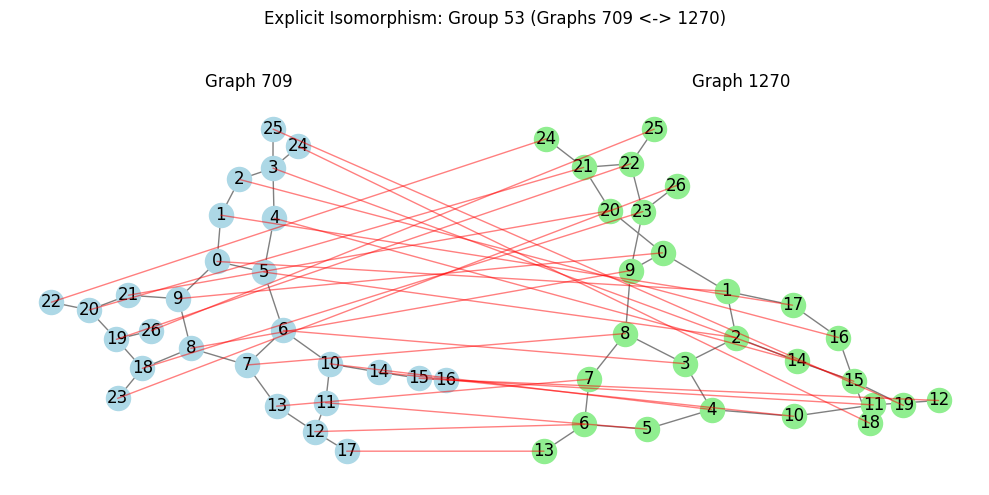

Group 18: Explicit isomorphism between Graph 189 and Graph 1004:
{1: 0, 4: 1, 5: 2, 0: 3, 3: 4, 2: 5, 6: 6, 7: 10, 8: 7, 10: 8, 11: 9, 9: 11}


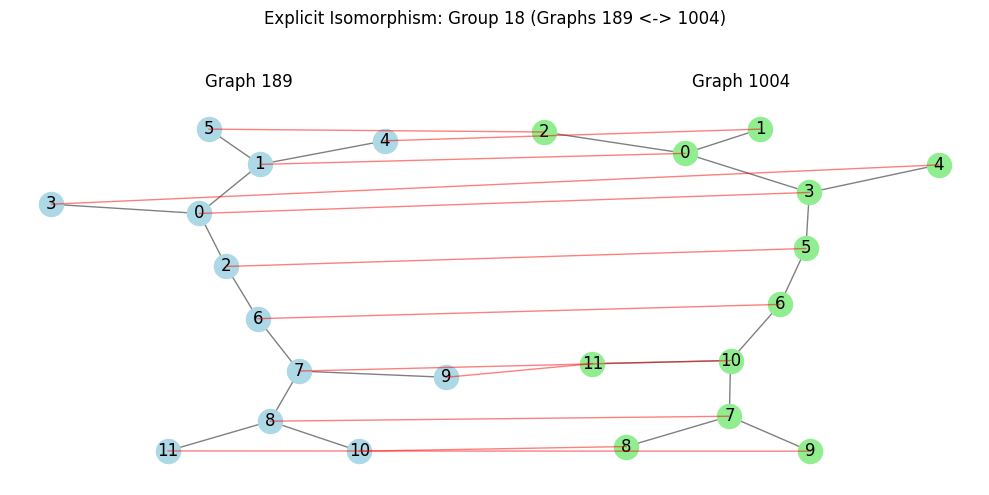

Group 37: Explicit isomorphism between Graph 435 and Graph 825:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21}


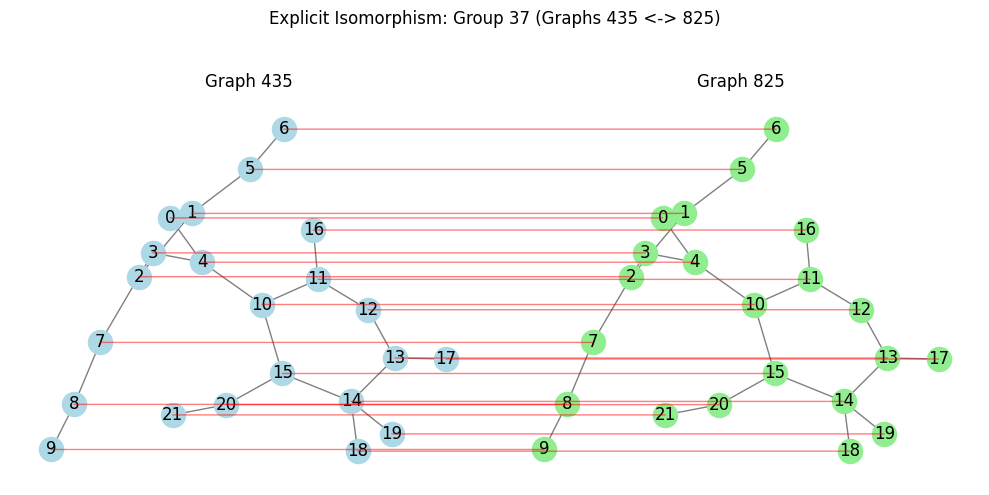

Group 41: Explicit isomorphism between Graph 470 and Graph 651:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21}


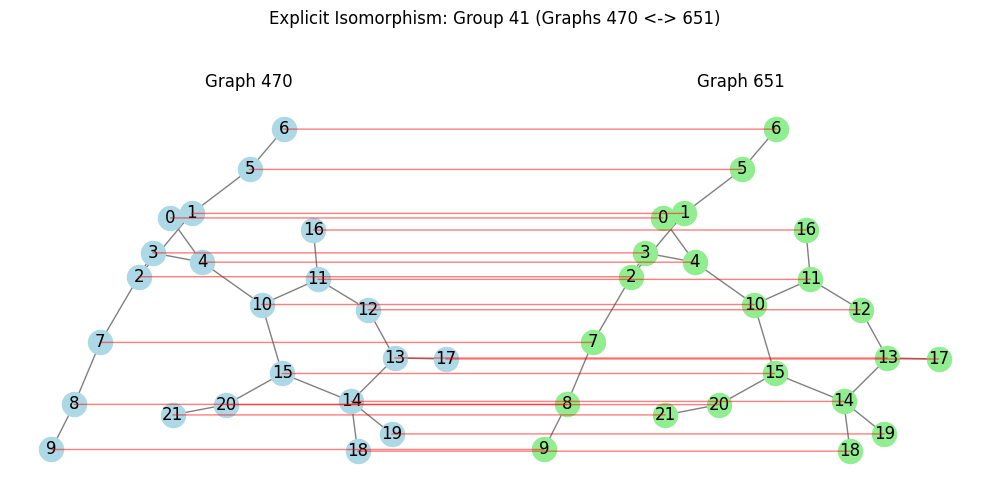

Group 48: Explicit isomorphism between Graph 592 and Graph 838:
{0: 0, 1: 1, 2: 2, 3: 3}


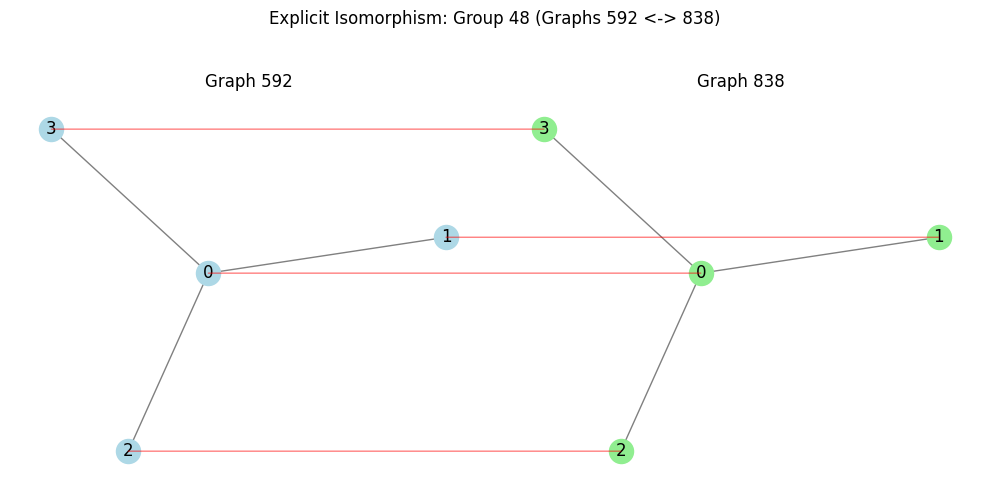

In [30]:
# Attempt to construct and visualize explicit isomorphisms for the top 5 groups with no structural difference
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from matplotlib.patches import ConnectionPatch  # Correct import

print("\nAttempting to construct explicit node-to-node isomorphisms for the top 5 groups with no structural difference:\n")
shown = 0
for group_id, group in sorted_groups:
    if shown >= 5:
        break
    if len(group) < 2:
        continue
    nx_graphs = pyg_group_to_nx_graphs(dataset, group)
    props = analyze_structural_properties(nx_graphs)
    if not all_structural_properties_identical(props):
        continue
    # Try to construct isomorphisms between the first two graphs in the group
    G1, G2 = nx_graphs[0], nx_graphs[1]
    GM = nx.isomorphism.GraphMatcher(G1, G2, node_match=lambda x, y: x['label'] == y['label'])
    if GM.is_isomorphic():
        mapping = GM.mapping
        print(f"Group {group_id}: Explicit isomorphism between Graph {group[0]} and Graph {group[1]}:")
        print(mapping)
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        pos1 = nx.spring_layout(G1, seed=42)
        pos2 = nx.spring_layout(G2, seed=42)
        nx.draw(G1, pos1, with_labels=True, node_color='lightblue', edge_color='gray', ax=axes[0])
        nx.draw(G2, pos2, with_labels=True, node_color='lightgreen', edge_color='gray', ax=axes[1])
        axes[0].set_title(f"Graph {group[0]}")
        axes[1].set_title(f"Graph {group[1]}")
        # Draw mapping as lines between corresponding nodes
        for n1, n2 in mapping.items():
            xyA = pos1[n1]
            xyB = pos2[n2]
            con = ConnectionPatch(xyA, xyB, "data", "data", axesA=axes[0], axesB=axes[1], color="red", alpha=0.5)
            fig.add_artist(con)
        plt.suptitle(f"Explicit Isomorphism: Group {group_id} (Graphs {group[0]} <-> {group[1]})")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        shown += 1
    else:
        print(f"Group {group_id}: No explicit isomorphism found between Graph {group[0]} and Graph {group[1]} (unexpected)")

In [31]:
# Summary: Which pairs were truly isomorphic, and which were 'WL-fakes'?

# Properties investigated:
# - Sorted degree sequence
# - Two-hop neighbor degree sequence
# - Triangle count
# - Four-cycle count
# - Explicit node-to-node isomorphism (using NetworkX's GraphMatcher with node labels)

true_isomorphic_groups = []
wl_fake_groups = []

for group_id, group in sorted_groups:
    if len(group) < 2:
        continue
    nx_graphs = pyg_group_to_nx_graphs(dataset, group)
    props = analyze_structural_properties(nx_graphs)
    if all_structural_properties_identical(props):
        # Try to construct isomorphism between the first two graphs
        G1, G2 = nx_graphs[0], nx_graphs[1]
        GM = nx.isomorphism.GraphMatcher(G1, G2, node_match=lambda x, y: x['label'] == y['label'])
        if GM.is_isomorphic():
            true_isomorphic_groups.append((group_id, group))
        else:
            wl_fake_groups.append((group_id, group))
    else:
        wl_fake_groups.append((group_id, group))

print("Truly isomorphic groups (WL test and all structural properties, and explicit isomorphism agree):")
for group_id, group in true_isomorphic_groups:
    print(f"  Group {group_id}: {group}")

print("\n'WL-fake' groups (WL test says isomorphic, but structural properties or explicit isomorphism disagree):")
for group_id, group in wl_fake_groups:
    print(f"  Group {group_id}: {group}")

print("\nProperties checked for each group:")
print("- Sorted degree sequence")
print("- Two-hop neighbor degree sequence")
print("- Triangle count")
print("- Four-cycle count")
print("- Explicit node-to-node isomorphism (NetworkX GraphMatcher with node labels)")

Truly isomorphic groups (WL test and all structural properties, and explicit isomorphism agree):
  Group 53: [709, 1270, 1454, 1585, 1607, 1809, 1964, 1977]
  Group 18: [189, 1004, 1711]
  Group 37: [435, 825, 1473]
  Group 41: [470, 651, 1739]
  Group 48: [592, 838, 1121]
  Group 54: [720, 839, 1329]
  Group 55: [763, 1458, 1776]
  Group 60: [853, 1084, 1836]
  Group 82: [1667, 1741, 1794]
  Group 1: [18, 1832]
  Group 2: [23, 1950]
  Group 3: [26, 1184]
  Group 4: [27, 666]
  Group 5: [48, 877]
  Group 6: [60, 1685]
  Group 7: [63, 751]
  Group 8: [78, 123]
  Group 9: [90, 711]
  Group 10: [120, 1825]
  Group 11: [125, 1505]
  Group 12: [127, 700]
  Group 13: [138, 234]
  Group 14: [142, 1909]
  Group 15: [153, 1617]
  Group 16: [160, 213]
  Group 17: [187, 603]
  Group 19: [197, 951]
  Group 20: [218, 239]
  Group 21: [219, 1071]
  Group 22: [230, 574]
  Group 23: [232, 878]
  Group 24: [235, 812]
  Group 25: [244, 1196]
  Group 26: [257, 856]
  Group 27: [262, 509]
  Group 28: [277